In [6]:
# goal - make a basic algo predicting direction of markets each week

# things I consider when trading
# swing highs/lows as S/R, bollinger bands, composite index, obv, relative volume, 
# market structure, macro conditions for general direction, weakness within wicks, ma's and ema's

import numpy as np;
import pandas as pd;

#Data source / yahoo finance
import yfinance as yf

#Data Visualization
import plotly.graph_objs as go

In [4]:
data = yf.download(tickers = "^GSPC", period = '40y', interval = '1d')

#Convert the 'Date' Index to 'Date' Column
data.reset_index(inplace=True)

#Create columns manipulating 'Date'
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Week of Year'] = data['Date'].dt.isocalendar().week
data['Day of Week'] = data['Date'].dt.dayofweek

#print data 
data

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day,Week of Year,Day of Week
0,1982-07-09,108.230003,108.970001,107.559998,108.830002,108.830002,65870000,1982,7,9,27,4
1,1982-07-12,109.480003,109.620003,108.889999,109.570000,109.570000,74690000,1982,7,12,28,0
2,1982-07-13,109.190002,110.070000,109.190002,109.449997,109.449997,66170000,1982,7,13,28,1
3,1982-07-14,109.680000,110.440002,109.080002,110.440002,110.440002,58160000,1982,7,14,28,2
4,1982-07-15,110.830002,110.949997,110.269997,110.470001,110.470001,61090000,1982,7,15,28,3
...,...,...,...,...,...,...,...,...,...,...,...,...
10080,2022-07-01,3781.000000,3829.820068,3752.100098,3825.330078,3825.330078,3268240000,2022,7,1,26,4
10081,2022-07-05,3792.610107,3832.189941,3742.060059,3831.389893,3831.389893,4427900000,2022,7,5,27,1
10082,2022-07-06,3831.979980,3870.909912,3809.370117,3845.080078,3845.080078,3613120000,2022,7,6,27,2
10083,2022-07-07,3858.850098,3910.629883,3858.850098,3902.620117,3902.620117,3337710000,2022,7,7,27,3


In [300]:
import talib as ta
#Create the daily change percentage and format it as a percent
data['LastClose'] = data['Close'].shift(1)
data['Change'] = 100*(data['Close'] - data['LastClose'])/data['LastClose']
data['ChangeFromOpen'] = 100*(data['Close'] - data['Open'])/data['Open']
data['CloseIn5'] = data['Close'].shift(-5)
data['5PeriodChange'] = 100*(data['CloseIn5'] - data['LastClose'])/data['LastClose']


#Create the yesterdays change percentage and format it as a percent
data['2LagClose'] = data['Close'].shift(2)
data['LastChange'] = 100*(data['LastClose'] - data['2LagClose'])/data['2LagClose']

# binary today outcome
data['Direction'] = np.where(data['5PeriodChange']>0, "Up", "Down")

#Create the regular bollinger band data
data['Middle Band'] = data['LastClose'].rolling(window=21).mean()
data['Upper Band'] = data['Middle Band'] + 1.96*data['LastClose'].rolling(window=21).std()
data['Lower Band'] = data['Middle Band'] - 1.96*data['LastClose'].rolling(window=21).std()
#create BB% data
data['BollingerBands%'] = (data['LastClose']-data['Lower Band']) / (data['Upper Band']-data['Lower Band'])

#Create the relative volume data
data['LastVolume'] = data['Volume'].shift(1)
data['Relative Volume Baseline'] = data['LastVolume'].rolling(window=20).mean()
data['Relative Volume'] = data['LastVolume']/data['Relative Volume Baseline']

# RSI
data['RSI'] = ta.RSI(data['LastClose'], timeperiod=14)

# Composite Index
data['RSIlagged'] = data['RSI'].shift(9)
data['delta'] = data['RSI'] - data['RSIlagged'] 
data['RSIsma'] = ta.SMA(data['RSI'], 3)
data['Composite Index'] = data['delta'] + data['RSIsma']

# SMA's and EMA's
data['50EMA'] = ta.EMA(data['LastClose'], 50)
data['10EMA'] = ta.EMA(data['LastClose'], 10)
#data['200SMA'] = ta.SMA(data['LastClose'], 200)

# trends
data['trend50'] = (data['LastClose'] - data['50EMA'])/data['LastClose']
data['trend10'] = (data['LastClose'] - data['10EMA'])/data['LastClose']
#data['trend200'] = (data['LastClose'] - data['200SMA'])/data['LastClose']

data

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day,Week of Year,Day of Week,LastClose,Change,ChangeFromOpen,CloseIn5,5periodChange,2LagClose,LastChange,5PeriodChange,Direction,Middle Band,Upper Band,Lower Band,BollingerBands%,LastVolume,Relative Volume Baseline,Relative Volume,RSI,RSIlagged,delta,RSIsma,Composite Index,50EMA,10EMA,trend50,trend10
0,1982-06-04,111.660004,111.849998,110.019997,110.089996,110.089996,44110000,1982,6,4,22,4,NaN,NaN,-1.406061,111.239998,NaN,NaN,NaN,NaN,Down,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1982-06-07,109.589996,110.589996,109.419998,110.120003,110.120003,44630000,1982,6,7,23,0,110.089996,0.027256,0.483627,109.959999,-0.118083,NaN,NaN,-0.118083,Down,NaN,NaN,NaN,NaN,4.411000e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1982-06-08,110.330002,110.330002,109.599998,109.629997,109.629997,46820000,1982,6,8,23,1,110.120003,-0.444974,-0.634464,109.690002,-0.390483,110.089996,0.027256,-0.390483,Down,NaN,NaN,NaN,NaN,4.463000e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1982-06-09,109.459999,109.629997,108.529999,108.989998,108.989998,55770000,1982,6,9,23,2,109.629997,-0.583781,-0.429382,108.870003,-0.693236,110.120003,-0.444974,-0.693236,Down,NaN,NaN,NaN,NaN,4.682000e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1982-06-10,109.349998,109.699997,108.959999,109.610001,109.610001,50950000,1982,6,10,23,3,108.989998,0.568862,0.237771,107.599998,-1.275346,109.629997,-0.583781,-1.275346,Down,NaN,NaN,NaN,NaN,5.577000e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10081,2022-05-27,4077.429932,4158.490234,4077.429932,4158.240234,4158.240234,3560560000,2022,5,27,21,4,4057.840088,2.474226,1.981893,NaN,NaN,3978.729980,1.988326,NaN,Down,4046.504767,4281.489546,3811.519987,0.524119,3.961940e+09,4.215942e+09,0.939752,47.670658,38.807082,8.863576,43.046638,51.910214,4197.013968,3993.555027,-0.034298,0.015842
10082,2022-05-31,4151.089844,4168.339844,4104.879883,4132.149902,4132.149902,5192220000,2022,5,31,22,1,4158.240234,-0.627437,-0.456264,NaN,NaN,4057.840088,2.474226,NaN,Down,4040.349540,4255.540964,3825.158115,0.773921,3.560560e+09,4.196796e+09,0.848400,53.719704,38.062573,15.657130,47.842490,63.499620,4195.493429,4023.497792,-0.008959,0.032404
10083,2022-06-01,4149.779785,4166.540039,4073.850098,4101.229980,4101.229980,4145710000,2022,6,1,22,2,4132.149902,-0.748277,-1.169937,NaN,NaN,4158.240234,-0.627437,NaN,Down,4040.360003,4255.569409,3825.150597,0.713257,5.192220e+09,4.232704e+09,1.226691,52.036339,43.957034,8.079305,51.142233,59.221538,4193.009370,4043.252721,-0.014728,0.021514
10084,2022-06-02,4095.409912,4177.509766,4074.370117,4176.819824,4176.819824,3604930000,2022,6,2,22,3,4101.229980,1.843102,1.987833,NaN,NaN,4132.149902,-0.748277,NaN,Down,4037.781436,4248.634034,3826.928838,0.650457,4.145710e+09,4.246112e+09,0.976354,50.035260,36.346096,13.689164,51.930434,65.619598,4189.410178,4053.794041,-0.021501,0.011566


In [301]:
# drop all rows with any NaN and NaT values
data = data.dropna()

# Labels are the values we want to predict
outcome = np.array(data['Direction'])
# Remove the labels from the features
# axis 1 refers to the columns
#inputs = ['Month', 'Day', 'Week of Year', 'Day of Week', 'LastChange', 'trend50', 'trend10', 'trend200', 'BollingerBands%', 'Relative Volume', 'Composite Index', 'delta', 'RSIsma']
inputs = ['LastChange', 'trend50', 'BollingerBands%','Composite Index']
X = data[inputs]
# Saving feature names for later use
feature_list = list(X.columns)
# Convert to numpy array
predictors = np.array(X)

In [302]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_predictors, test_predictors, train_outcome, test_outcome = train_test_split(predictors, outcome, test_size = 0.2, random_state = 1234)

In [303]:
print('Training Features Shape:', train_predictors.shape)
print('Training Labels Shape:', train_outcome.shape)
print('Testing Features Shape:', test_predictors.shape)
print('Testing Labels Shape:', test_outcome.shape)

Training Features Shape: (8024, 4)
Training Labels Shape: (8024,)
Testing Features Shape: (2007, 4)
Testing Labels Shape: (2007,)


In [304]:
data['Direction'].value_counts()

Up      5838
Down    4193
Name: Direction, dtype: int64

In [306]:
# Baseline goal
5838/(5838+4193)

0.5819958129797628

In [307]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 10000, random_state = 1234, max_features = 2)
# Train the model on training data
rf.fit(train_predictors, train_outcome);

In [308]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_predictors)

# metrics are used to find accuracy or error
from sklearn import metrics 
print()
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(test_outcome, predictions))


ACCURACY OF THE MODEL:  0.5550572994519183


In [309]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(test_outcome, predictions, labels = ["Up","Down"])
print(conf_mat)

[[869 296]
 [597 245]]


In [311]:
#                      Prediction
#                   UP             DOWN
# Actual   UP       686           410
#          DOWN     536           385

(869)/(869+597)

0.5927694406548432

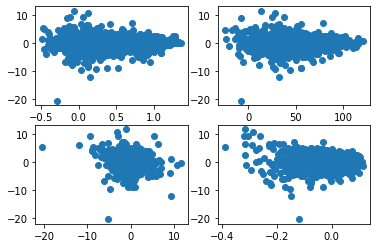

In [312]:
import matplotlib.pyplot as plt
plt.subplot(2,2,1)
plt.scatter(X['BollingerBands%'],data['Change'])
plt.subplot(2,2,2)
plt.scatter(X['Composite Index'],data['Change'])
plt.subplot(2,2,3)
plt.scatter(X['LastChange'],data['Change'])
plt.subplot(2,2,4)
plt.scatter(X['trend50'],data['Change'])

In [313]:
from pandas import DataFrame
import statsmodels.api as sm

inputs = ['LastChange', 'trend50', 'BollingerBands%','Composite Index']
X = data[inputs]
Y = data['Change']

X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                 Change   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     22.67
Date:                Fri, 03 Jun 2022   Prob (F-statistic):           1.14e-18
Time:                        17:31:34   Log-Likelihood:                -15514.
No. Observations:               10031   AIC:                         3.104e+04
Df Residuals:                   10026   BIC:                         3.107e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1107      0.042     

In [314]:
data.corr()

,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day,Week of Year,Day of Week,LastClose,Change,ChangeFromOpen,CloseIn5,5periodChange,2LagClose,LastChange,5PeriodChange,Middle Band,Upper Band,Lower Band,BollingerBands%,LastVolume,Relative Volume Baseline,Relative Volume,RSI,RSIlagged,delta,RSIsma,Composite Index,50EMA,10EMA,trend50,trend10
Open,1.000000,0.999955,0.999929,0.999882,0.999882,0.658640,0.886482,-0.012544,-0.001557,-0.012800,0.001239,0.999978,-0.009955,-0.021851,0.999226,-0.026383,0.999827,0.001290,-0.026383,0.999112,0.998109,0.998945,0.038183,0.658209,0.678154,-0.011355,0.045001,0.048887,-0.003854,0.046913,0.024759,0.998588,0.999707,0.018151,0.002824
High,0.999955,1.000000,0.999906,0.999937,0.999937,0.659891,0.886654,-0.012790,-0.001664,-0.013036,0.001221,0.999922,-0.004441,-0.016412,0.999272,-0.024128,0.999803,0.000037,-0.024128,0.999228,0.998354,0.998923,0.035647,0.659464,0.679167,-0.010679,0.042150,0.047338,-0.005126,0.044202,0.022412,0.998770,0.999741,0.014734,-0.000088
Low,0.999929,0.999906,1.000000,0.999943,0.999943,0.656760,0.886322,-0.012032,-0.001397,-0.012306,0.001083,0.999885,-0.002965,-0.015134,0.999273,-0.023639,0.999716,0.002144,-0.023639,0.998864,0.997722,0.998845,0.040502,0.656819,0.677137,-0.012451,0.047546,0.050503,-0.002945,0.049334,0.026715,0.998278,0.999536,0.021287,0.005303
Close,0.999882,0.999937,0.999943,1.000000,1.000000,0.658269,0.886516,-0.012504,-0.001744,-0.012796,0.001201,0.999836,0.002368,-0.009654,0.999307,-0.021676,0.999712,0.000218,-0.021676,0.999007,0.998014,0.998829,0.037806,0.658266,0.678249,-0.011497,0.044503,0.048860,-0.004314,0.046508,0.024242,0.998494,0.999591,0.017422,0.001860
Adj Close,0.999882,0.999937,0.999943,1.000000,1.000000,0.658269,0.886516,-0.012504,-0.001744,-0.012796,0.001201,0.999836,0.002368,-0.009654,0.999307,-0.021676,0.999712,0.000218,-0.021676,0.999007,0.998014,0.998829,0.037806,0.658266,0.678249,-0.011497,0.044503,0.048860,-0.004314,0.046508,0.024242,0.998494,0.999591,0.017422,0.001860
Volume,0.658640,0.659891,0.656760,0.658269,0.658269,1.000000,0.844716,-0.040989,-0.012220,-0.038260,0.024219,0.658773,-0.022393,-0.026623,0.658236,-0.027242,0.659335,-0.032320,-0.027242,0.662876,0.668313,0.656265,-0.047155,0.966017,0.961099,0.078145,-0.064549,-0.040405,-0.023602,-0.062520,-0.050604,0.666654,0.660887,-0.170147,-0.104572
Year,0.886482,0.886654,0.886322,0.886516,0.886516,0.844716,1.000000,-0.033314,-0.003262,-0.032587,0.002302,0.886529,-0.008071,-0.016782,0.886419,-0.021050,0.886537,-0.008621,-0.021050,0.887017,0.886695,0.886263,0.011750,0.844594,0.868911,-0.010304,0.008077,0.013956,-0.005770,0.009177,0.001770,0.888482,0.886855,-0.055474,-0.030509
Month,-0.012544,-0.012790,-0.012032,-0.012504,-0.012504,-0.040989,-0.033314,1.000000,-0.000308,0.978377,-0.012146,-0.012697,0.002359,-0.002320,-0.011659,0.008650,-0.012899,0.004077,0.008650,-0.013881,-0.015061,-0.012606,0.004485,-0.035876,-0.019047,-0.073908,-0.016173,-0.049434,0.032618,-0.022451,0.007007,-0.013524,-0.013357,-0.059636,-0.004231
Day,-0.001557,-0.001664,-0.001397,-0.001744,-0.001744,-0.012220,-0.003262,-0.000308,1.000000,0.063750,-0.000760,-0.001505,-0.008657,-0.007719,-0.000501,0.040175,-0.001508,-0.005309,0.040175,-0.001056,-0.000399,-0.001754,-0.024867,-0.018371,-0.002841,-0.076541,-0.021337,0.004337,-0.025145,-0.019096,-0.026446,-0.000862,-0.001055,-0.020361,-0.033015
Week of Year,-0.012800,-0.013036,-0.012306,-0.012796,-0.012796,-0.038260,-0.032587,0.978377,0.063750,1.000000,-0.014277,-0.012950,-0.000607,-0.005334,-0.011884,0.008256,-0.013141,0.001513,0.008256,-0.014050,-0.015113,-0.012901,0.001313,-0.032452,-0.018098,-0.061840,-0.021175,-0.046156,0.024507,-0.026922,-0.000547,-0.013660,-0.013524,-0.063203,-0.009723


In [315]:
from scipy.stats import pearsonr

pd. set_option('display.max_columns', None)

def calculate_pvalues(data):
    data = data.dropna()._get_numeric_data()
    datacols = pd.DataFrame(columns=data.columns)
    pvalues = datacols.transpose().join(datacols, how='outer')
    for r in data.columns:
        for c in data.columns:
            pvalues[r][c] = round(pearsonr(data[r], data[c])[1], 4)
    return pvalues

calculate_pvalues(data)

,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day,Week of Year,Day of Week,LastClose,Change,ChangeFromOpen,CloseIn5,5periodChange,2LagClose,LastChange,5PeriodChange,Middle Band,Upper Band,Lower Band,BollingerBands%,LastVolume,Relative Volume Baseline,Relative Volume,RSI,RSIlagged,delta,RSIsma,Composite Index,50EMA,10EMA,trend50,trend10
Open,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.209,0.8761,0.1999,0.9013,0.0,0.3188,0.0286,0.0,0.0082,0.0,0.8972,0.0082,0.0,0.0,0.0,0.0001,0.0,0.0,0.2555,0.0,0.0,0.6996,0.0,0.0131,0.0,0.0,0.0691,0.7773
High,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2002,0.8677,0.1917,0.9027,0.0,0.6565,0.1003,0.0,0.0157,0.0,0.997,0.0157,0.0,0.0,0.0,0.0004,0.0,0.0,0.2849,0.0,0.0,0.6077,0.0,0.0248,0.0,0.0,0.1401,0.9929
Low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2282,0.8887,0.2178,0.9137,0.0,0.7665,0.1296,0.0,0.0179,0.0,0.83,0.0179,0.0,0.0,0.0,0.0,0.0,0.0,0.2124,0.0,0.0,0.768,0.0,0.0075,0.0,0.0,0.033,0.5954
Close,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2105,0.8613,0.2,0.9043,0.0,0.8126,0.3336,0.0,0.0299,0.0,0.9826,0.0299,0.0,0.0,0.0,0.0002,0.0,0.0,0.2496,0.0,0.0,0.6657,0.0,0.0152,0.0,0.0,0.081,0.8522
Adj Close,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2105,0.8613,0.2,0.9043,0.0,0.8126,0.3336,0.0,0.0299,0.0,0.9826,0.0299,0.0,0.0,0.0,0.0002,0.0,0.0,0.2496,0.0,0.0,0.6657,0.0,0.0152,0.0,0.0,0.081,0.8522
Volume,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.221,0.0001,0.0153,0.0,0.0249,0.0077,0.0,0.0064,0.0,0.0012,0.0064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0001,0.0181,0.0,0.0,0.0,0.0,0.0,0.0
Year,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0008,0.7439,0.0011,0.8177,0.0,0.4189,0.0928,0.0,0.035,0.0,0.3879,0.035,0.0,0.0,0.0,0.2393,0.0,0.0,0.3021,0.4186,0.1622,0.5634,0.3581,0.8593,0.0,0.0,0.0,0.0022
Month,0.209,0.2002,0.2282,0.2105,0.2105,0.0,0.0008,0.0,0.9754,0.0,0.2238,0.2035,0.8132,0.8163,0.243,0.3864,0.1964,0.683,0.3864,0.1645,0.1315,0.2068,0.6533,0.0003,0.0564,0.0,0.1053,0.0,0.0011,0.0245,0.4829,0.1756,0.181,0.0,0.6718
Day,0.8761,0.8677,0.8887,0.8613,0.8613,0.221,0.7439,0.9754,0.0,0.0,0.9393,0.8802,0.386,0.4395,0.96,0.0001,0.88,0.595,0.0001,0.9158,0.9681,0.8606,0.0128,0.0658,0.776,0.0,0.0326,0.664,0.0118,0.0558,0.0081,0.9312,0.9159,0.0414,0.0009
Week of Year,0.1999,0.1917,0.2178,0.2,0.2,0.0001,0.0011,0.0,0.0,0.0,0.1528,0.1947,0.9515,0.5932,0.234,0.4083,0.1881,0.8796,0.4083,0.1594,0.1301,0.1964,0.8954,0.0012,0.0699,0.0,0.0339,0.0,0.0141,0.007,0.9563,0.1713,0.1756,0.0,0.3302


In [316]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
from sklearn import datasets

# define pred and response vars
inputs = ['LastChange', 'trend50', 'BollingerBands%','Composite Index']
X = data[inputs]
Y = data['Direction']

#Fit the QDA model
model = QuadraticDiscriminantAnalysis()
model.fit(X, Y)

QuadraticDiscriminantAnalysis()

In [317]:
#Define method to evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = cross_val_score(model, X, Y, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))   

0.5786395792701576


In [318]:
predictions

50       0.102549
51       0.138492
52      -0.343973
53      -0.002425
54      -0.137095
           ...   
10076    0.179133
10077    0.122690
10078   -0.023200
10079    0.154969
10080    0.011411
Length: 10031, dtype: float64